In [2]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader, Dataset

torch.cuda.is_available()
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
print('Torch running on:', device)

Torch running on: cuda:0


## DataLoaders

In [3]:
# load data in numpy
def load_turbo2D_simple_numpy(path_to_turbo2D, ds=4, img=42):
    """
    ds : down-scaling factor (1 = nothing, 2=every 2 samples, ...)
    img : index of the image (max is 55)
    
    returns: 
        X flatten coordinate grid (R^2)x2
        y flatten target velocity field (R^2)x2
    """
    
    assert img < 55

    IMGs = np.load(path_to_turbo2D)
    img = img
    X = IMGs[img,::ds,::ds,:2] / 255
    U = IMGs[img,::ds,::ds,2:]

    # normalize output
    y = U.copy()
    print('Y shape', y.shape)
    print('Y min, max:', np.min(y), np.max(y))
    y = y / np.max(np.abs(y))
    print('after normalization, Y min, max:', np.min(y), np.max(y))

    X = X.reshape(-1,2)
    y = y.reshape(-1,2)

    assert X.shape == y.shape

    return X, y


class Turbo2D_simple(Dataset):
    
    def __init__(self, path_to_turbo2D, device, ds=4, img=42):
        
        print('Dataset Turbo2D, img #', img)

        IMGs = np.load(path_to_turbo2D)
        X = IMGs[img,::ds,::ds,:2] / 255
        U = IMGs[img,::ds,::ds,2:]

        print(X.shape)
        print(U.shape)

        original_size = X.shape[0]
        print('Original size', original_size)

        # normalize output
        y = U.copy()
        print('Y shape', y.shape)
        print('Y min, max:', np.min(y), np.max(y))
        y = y / np.max(np.abs(y))
        
        print('after normalization, Y min, max:', np.min(y), np.max(y))

        self.x = torch.from_numpy(X).float().to(device).view(-1,2)
        self.y = torch.from_numpy(y).float().to(device).view(-1,2)

        assert self.x.shape[0] == self.y.shape[0]

    
    def __len__(self):
        return self.x.shape[0]
    

    def __getitem__(self, idx):
        x = self.x[idx,:]
        y = self.y[idx,:]
        return (x, y)
    

*optional*: load groundtruth data in numpy.

This might be usefull for plotting

In [4]:
path_to_turbo2D = '../data/2021-Turb2D_velocities.npy'
img_idx = 42

# optional: load groundtruth data in numpy.
#           usefull for plotting
Xlr, ulr = load_turbo2D_simple_numpy(path_to_turbo2D, ds=4, img=img_idx) # LR data
Xhr, uhr = load_turbo2D_simple_numpy(path_to_turbo2D, ds=1, img=img_idx) # HR data

L = int(Xlr.shape[0]**0.5)
H = int(Xhr.shape[0]**0.5)

print('Img res:', L, 'Input batch:', Xlr.shape) # LR data
print('Img res:', H, 'Input batch:', Xhr.shape) # HR data

Y shape (64, 64, 2)
Y min, max: -2.365612 2.941536
after normalization, Y min, max: -0.8042097733972999 1.0
Y shape (256, 256, 2)
Y min, max: -2.382122 2.999472
after normalization, Y min, max: -0.7941804424245333 1.0
Img res: 64 Input batch: (4096, 2)
Img res: 256 Input batch: (65536, 2)


training data in pytorch dataset

In [5]:
trainset = Turbo2D_simple(path_to_turbo2D, device, ds=4, img=42)
trainloader = DataLoader(trainset, batch_size=6666, shuffle=False)

Dataset Turbo2D, img # 42
(64, 64, 2)
(64, 64, 2)
Original size 64
Y shape (64, 64, 2)
Y min, max: -2.365612 2.941536
after normalization, Y min, max: -0.8042097733972999 1.0


# Basics building block of our model

In [6]:
class Fourier(nn.Module):
    """
    Compute Random Fourier Features:
        sin(2*pi*B*x) and cos(2*pi*B*x)
        B : matrix n_featuresx2
        x : input vector n_batchx2        
    """
    
    def __init__(self, nfeat, scale):
        super(Fourier, self).__init__()
        self.b = nn.Parameter(torch.randn(2, nfeat)*scale, requires_grad=False)
        self.pi = 3.14159265359 # better to hardcode this, rather than use np.pi

    def forward(self, x):
        x = torch.einsum('bc,cf->bf', 2*self.pi*x, self.b.to(x.device))
        return torch.cat([torch.sin(x), torch.cos(x)], -1)

    
def LinearReLU(n_in, n_out):
    """
    Simple block Linear + ReLU
    """
    block = nn.Sequential(
      nn.Linear(n_in, n_out),
      nn.ReLU()
    )
    return block


def LinearTanh(n_in, n_out):
    """
    Simple block Linear + Tanh
    # Tanh is C^\infty and it may be better when computing high order derivates
    """
    block = nn.Sequential(
      nn.Linear(n_in, n_out),
      nn.Tanh()
    )
    return block

In [11]:
class MLP(nn.Module):
    """
    Simple MLP
        - dim_layes in a list [Nin] + [H_1] + [...] + [Nout]:
            e.g. [2] + 3*[256] + [2]
        - last_activation_fun : a nn.Module
            e.g. nn.Tanh(), nn.Sigmoid(), or nn.ReLU()
    """
    
    def __init__(self, dim_layers):
        super(MLP, self).__init__()
        layers = []
        num_layers = len(dim_layers)
        
        blocks = []
        for l in range(num_layers-2):
            blocks.append(LinearTanh(dim_layers[l], dim_layers[l+1]))
            
        blocks.append(nn.Linear(dim_layers[-2], dim_layers[-1]))
        blocks.append(nn.Tanh())
        self.network = nn.Sequential(*blocks)
    
    def forward(self, x):
        return self.network(x)

Putting all the blocks together

In [86]:
class DivFreeRFFNet(nn.Module):
    
    def __init__(self, name, 
                    dim_mpl_layers,
                    do_rff, f_nfeatures, f_scale, lam_pde=1, 
                    verbose=True):
        
        super(DivFreeRFFNet, self).__init__()
        self.name = name
        self.verbose = verbose

        assert dim_mpl_layers[-1] == 1
        
        # regression/pinn network 
        self.do_rff = do_rff
        if do_rff:
            self.rff = Fourier(f_nfeatures, f_scale) # directly the random matrix 'cause of checkpoint and load
            dim_mpl_layers[0] = dim_mpl_layers[0]*f_nfeatures
            self.rff = Fourier(f_nfeatures, f_scale)

        self.mlp = MLP(dim_mpl_layers)
        
        self.lam_pde = lam_pde # regularizer for divergence solft constraint

        # for log of the losses
        self.loss = []
        self.loss_pde = []
        self.loss_rec = []
        
        
    def forward(self, xin): # x := BxC(Batch, InputChannels)
        
        xin.requires_grad_(True)
        
        ## Fourier features
        if self.do_rff:
            x = self.rff(xin) # Batch x Fourier Features
            ## MLP
            x = self.mlp(x)
        else:
            ## MLP
            x = self.mlp(xin)

        # at this point x in the potential
        potential = x
        
        # now we need to compute the velocities, i.d. the dP/dx
        du_dxy = torch.autograd.grad(x, xin, torch.ones_like(x), create_graph=True)[0]
        div_free_uv = torch.cat([du_dxy[:,1,None], 
                                -du_dxy[:,0,None]], dim=-1)
        potential = x
        return div_free_uv, potential
    
    def compute_ux(self, xin):
        xin.requires_grad_(True)
        y, Py = self.forward(xin)
        du_xy = torch.autograd.grad(Py, xin, torch.ones_like(Py), create_graph=True)[0]       
        return du_xy

    def fit(self, trainloader, epochs=1000):
        self.train()
        optimiser = torch.optim.Adam(self.parameters(), lr=1e-4)
        epoch = 0
        while epoch < epochs or loss < 1e-6:
            epoch += 1
            current_loss = 0
            batches = 0
            for x_batch, y_batch in trainloader:
                batches += 1
                optimiser.zero_grad()
                
                # FORWARD
                y_hat, potential_hat = self.forward(x_batch)
                
                # LOSS
                loss_rec = (1/batches)*F.mse_loss(y_hat, y_batch)
                
                # check div=0
                u, v = torch.split(y_hat,1,-1)
                du_xy = torch.autograd.grad(u, x_batch, torch.ones_like(u), create_graph=True)[0]       
                dv_xy = torch.autograd.grad(v, x_batch, torch.ones_like(v), create_graph=True)[0]
                div_u_xy = du_xy[...,0] + dv_xy[...,1]
                loss_pde = (1/batches)*torch.norm(div_u_xy)**2
            
                # the network is div-free by construction,
                # so we optimize against the loss_rec only.
                # We compute loss_pde for logging
                loss = loss_rec # + self.lam_pde*loss_pde
                current_loss +=  loss.item() - current_loss

                self.loss_rec.append(loss_rec.item())
                self.loss_pde.append(self.lam_pde*loss_pde.item())

                # BACKWARD
                loss.backward()
                optimiser.step()
                
                # LOG
                if self.verbose and (epoch % 100 == 0 or epoch == 1):
                    print('Epoch: %4d, Loss: (rec: [%f] + %1.2f * div-free: [%f]) = %f' %
                     (epoch, loss_rec.item(), self.lam_pde, loss_pde.item(), current_loss))

        print('Done with Training')
        print('Final error:', current_loss)

MLP + DivFree(autograd)  --- no RFF

In [73]:
def to_numpy(x):
    return x.detach().cpu().numpy()

def to_torch(x):
    return torch.from_numpy(x).float().to(device)

In [74]:
# model (RFF + MLP)
do_rff = True   # <--------
fft_scale = 10  # <--------
fft_nfeat = 256 # <--------

nin = 2  # = x and y coordinates
nout = 1 # = in the mlp we predict the potential, ux and uy components followed
mlp_layers = [nin] + [256]*3 + [nout] # if do_rff, the first layer is 2*n_features, but this is already handled by the class construction

model = DivFreeRFFNet('DivFreeNet_RFF', mlp_layers,
                      do_rff, fft_nfeat, fft_scale, verbose=True)

# TRAIN!
model.to(device)
model.fit(trainloader, epochs=10) # we are not afraid to overfit the data, this is coord-based MLP!

Epoch:    1, Loss: (rec: [14.955189] + 1.00 * div-free: [0.000030]) = 14.955189
Done with Training
Final error: 1.4382433891296387


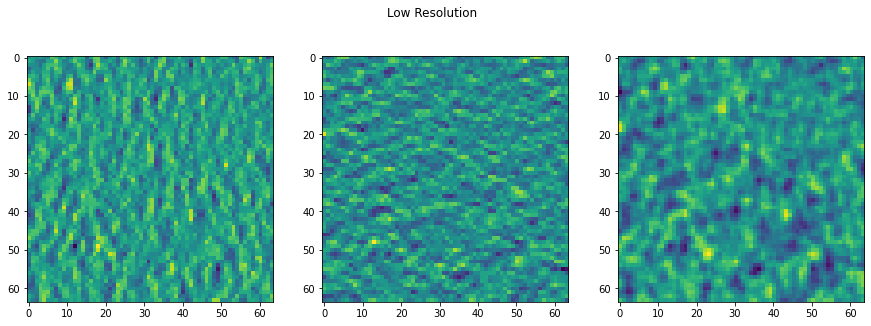

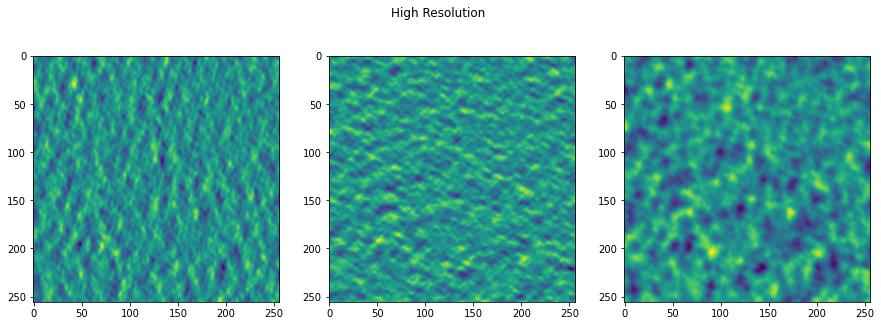

In [75]:
# TEST
model.eval().to(device)
ulr_pred, Plr_pred = model(to_torch(Xlr))
uhr_pred, Phr_pred = model(to_torch(Xhr))

ulr_pred = to_numpy(ulr_pred)
Plr_pred = to_numpy(Plr_pred)

uhr_pred = to_numpy(uhr_pred)
Phr_pred = to_numpy(Phr_pred)

# PLOT

plt.figure(figsize=(15,5))
plt.subplot(131)
plt.imshow(ulr_pred[:,0].reshape(L,L))
plt.subplot(132)
plt.imshow(ulr_pred[:,1].reshape(L,L))
plt.subplot(133)
plt.imshow(Plr_pred.reshape(L,L))
plt.suptitle('Low Resolution')
plt.show()

plt.figure(figsize=(15,5))
plt.subplot(131)
plt.imshow(uhr_pred[:,0].reshape(H,H))
plt.subplot(132)
plt.imshow(uhr_pred[:,1].reshape(H,H))
plt.subplot(133)
plt.imshow(Phr_pred.reshape(H,H))
plt.suptitle('High Resolution')
plt.show()

RFF + MLP + DivFree(autograd)

In [76]:
# model (RFF + MLP)
do_rff = False   # <--------
fft_scale = 10   
fft_nfeat = 256  

nin = 2  # = x and y coordinates
nout = 1 # = in the mlp we predict the potential, ux and uy components followed
mlp_layers = [nin] + [256]*3 + [nout] # if do_rff, the first layer is 2*n_features, but this is already handled by the class construction
last_activation_fun = torch.nn.Tanh()

model = DivFreeRFFNet('DivFreeNet_RFF', mlp_layers,
                      do_rff, fft_nfeat, fft_scale, verbose=True)

# TRAIN!
model.to(device)
model.fit(trainloader, epochs=10) # we are not afraid to overfit the data, this is coord-based MLP!

Epoch:    1, Loss: (rec: [0.070128] + 1.00 * div-free: [0.000000]) = 0.070128
Done with Training
Final error: 0.06537241488695145


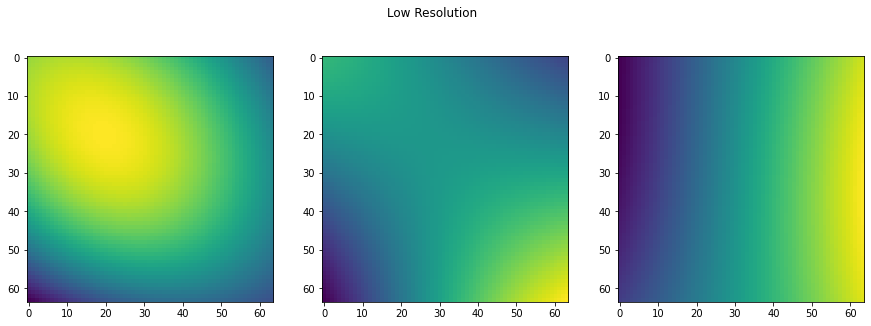

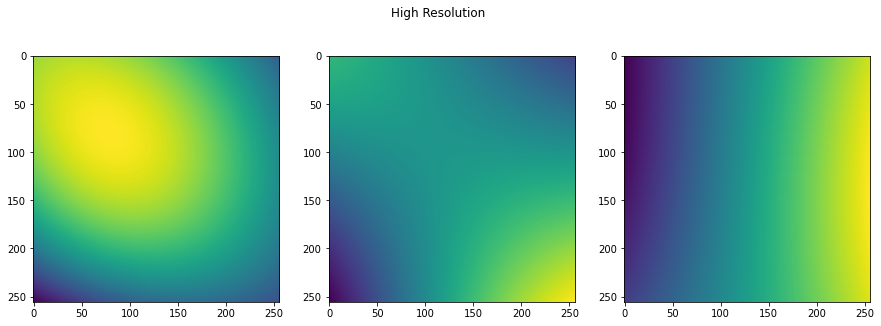

In [77]:
# TEST
model.eval().to(device)
ulr_pred, Plr_pred = model(to_torch(Xlr))
uhr_pred, Phr_pred = model(to_torch(Xhr))

ulr_pred = to_numpy(ulr_pred)
Plr_pred = to_numpy(Plr_pred)

uhr_pred = to_numpy(uhr_pred)
Phr_pred = to_numpy(Phr_pred)

# PLOT

plt.figure(figsize=(15,5))
plt.subplot(131)
plt.imshow(ulr_pred[:,0].reshape(L,L))
plt.subplot(132)
plt.imshow(ulr_pred[:,1].reshape(L,L))
plt.subplot(133)
plt.imshow(Plr_pred.reshape(L,L))
plt.suptitle('Low Resolution')
plt.show()

plt.figure(figsize=(15,5))
plt.subplot(131)
plt.imshow(uhr_pred[:,0].reshape(H,H))
plt.subplot(132)
plt.imshow(uhr_pred[:,1].reshape(H,H))
plt.subplot(133)
plt.imshow(Phr_pred.reshape(H,H))
plt.suptitle('High Resolution')
plt.show()

In [78]:
class MLPhard(nn.Module):
    
    def __init__(self, dim_layers, do_rff, nfeat, scale):
        super(MLPhard, self).__init__()
    
        self.do_rff = do_rff
        if self.do_rff:
            self.rff = Fourier(nfeat, scale) # directly the random matrix 'cause of checkpoint and load
            dim_layers[0] = dim_layers[0]*nfeat
            
    
        num_layers = len(dim_layers)
        
        blocks = []
        for l in range(num_layers-2):
            blocks.append(LinearTanh(dim_layers[l], dim_layers[l+1]))
            
        blocks.append(
            nn.Sequential(
                nn.Linear(dim_layers[-2], dim_layers[-1]),
                nn.Tanh()
            )
        )
            
        self.mlp = nn.Sequential(*blocks)
    
        # hardcoded derivates
        self.sigma1 = lambda x : torch.tanh(x)
        self.dsigma1 = lambda x : 1 - torch.tanh(x)**2
        
        self.sigma2 = lambda x : torch.sigmoid(x)
        self.dsigma2 = lambda x : torch.sigmoid(x)*(1 - torch.sigmoid(x))
        
        self.sincos = lambda x : torch.cat([torch.sin(x), torch.cos(x)], -1)
        self.dsincos = lambda x : torch.cat([torch.cos(x), -torch.sin(x)], -1)
        

    def forward(self, x):
        if self.do_rff:
            x = self.rff(x)
        x = self.mlp(x)
        return x

    def get_wb(self, depth):
        """
        get weights and biases
        """
        return self.mlp[depth][0].weight, self.mlp[depth][0].bias
        
    def compute_ux_rff(self, x):
        # Derivivate of the RFF
        Wr = self.rff.b
        Wr2 = torch.cat([Wr, Wr], axis=1).T
        
        dr = 2*self.rff.pi*self.dsincos(2*self.rff.pi*x @ Wr) # B x nfeat
        ar = self.sincos(2*self.rff.pi*x @ Wr) # B x nfeat

        # Derivate of the MLP
        W1, b1 = self.get_wb(0)
        d1 = self.dsigma1(ar @ W1.T + b1)
        a1 = self.sigma1(ar @ W1.T + b1) 
        # intermidiate
        # z = ((d1 @ W1) * dr) @ Wr2
        
        W2, b2 = self.get_wb(1)
        d2 = self.dsigma1(a1 @ W2.T + b2)
        a2 = self.sigma1(a1 @ W2.T + b2)
        # intermidiate
        # z = ((((d2 @ W2) * d1) @ W1) * dr) @ Wr2
        
        W3, b3 = self.get_wb(2)
        d3 = self.dsigma1(a2 @ W3.T + b3)
        a3 = self.sigma1(a2 @ W3.T + b3)
        # intermidiate
        # z = (((((d3 @ W3 * d2) @ W2) * d1) @ W1) * dr) @ Wr2
        
        W4, b4 = self.get_wb(3)
        d4 = self.dsigma1(a3 @ W4.T + b4)
        a4 = self.sigma1(a3 @ W4.T + b4)        
        z = ((((((d4 @ W4 * d3) @ W3 * d2) @ W2) * d1) @ W1) * dr) @ Wr2
        
        return z
    
    def compute_ux_no_rff(self, x):
        # Derivate of the MLP
        W1, b1 = self.get_wb(0)
        d1 = self.dsigma1(x @ W1.T + b1)
        a1 = self.sigma1(x @ W1.T + b1)
        # intermidiate
        # z = d1 @ W1
        
        W2, b2 = self.get_wb(1)
        d2 = self.dsigma1(a1 @ W2.T + b2)
        a2 = self.sigma1(a1 @ W2.T + b2)
        # intermidiate
        # z = (d2 @ W2) * d1) @ W1
        
        W3, b3 = self.get_wb(2)
        d3 = self.dsigma1(a2 @ W3.T + b3)
        a3 = self.sigma1(a2 @ W3.T + b3)
        # intermidiate
        # z = (d3 @ W3 * d2) @ W2 * d1) @ W1
        
        W4, b4 = self.get_wb(3)
        d4 = self.dsigma1(a3 @ W4.T + b4)
        a4 = self.sigma1(a3 @ W4.T + b4)        
        z = (((d4 @ W4 * d3) @ W3 * d2) @ W2 * d1) @ W1
        
        return z
    
class HardcodedDivFreeRFFNet(nn.Module):
    
    def __init__(self, name, dim_mpl_layers,
                    do_rff, f_nfeatures, f_scale, lam_pde=1, 
                    hardcoded_divfree=False, verbose=True):
        super(HardcodedDivFreeRFFNet, self).__init__()
        self.name = name
        self.verbose = verbose

        assert dim_mpl_layers[-1] == 1
        
        # regression/pinn network 
        self.do_rff = do_rff
        self.mlp = MLPhard(dim_mpl_layers, self.do_rff, f_nfeatures, f_scale)
        
        self.lam_pde = lam_pde

        self.loss = []
        self.loss_pde = []
        self.loss_rec = []
        
    def forward(self, xin): # x := BxC(Batch, InputChannels)
        ## implement periodicity
        xin.requires_grad_(True)
        
        ## RFF + MLP
        x = self.mlp(xin)
        ## DivFREE
        if self.do_rff:
            du_dxy = self.mlp.compute_ux_rff(xin)
        else:
            du_dxy = self.mlp.compute_ux_no_rff(xin)

        div_free_uv = torch.cat([du_dxy[:,1,None], 
                                -du_dxy[:,0,None]], dim=-1)
        potential = x
        return div_free_uv, potential
    
    def compute_ux_no_rff(self, xin):
        return self.mlp.compute_ux_no_rff(xin)
    
    def compute_ux_rff(self, xin):
        return self.mlp.compute_ux_rff(xin)

    def fit(self, trainloader, epochs=1000):
        self.train()
        optimiser = torch.optim.Adam(self.parameters(), lr=1e-4)
        epoch = 0
        while epoch < epochs or loss < 1e-6:
            epoch += 1
            current_loss = 0
            batches = 0
            for x_batch, y_batch in trainloader:
                batches += 1
                optimiser.zero_grad()
                y_hat, potential_hat = self.forward(x_batch)

                # check div=0
                u, v = torch.split(y_hat,1,-1)
                du_xy = torch.autograd.grad(u, x_batch, torch.ones_like(u), create_graph=True)[0]       
                dv_xy = torch.autograd.grad(v, x_batch, torch.ones_like(v), create_graph=True)[0]
                div_u_xy = du_xy[...,0] + dv_xy[...,1]
                loss_pde = (1/batches)*torch.norm(div_u_xy)**2
            
                loss_rec = (1/batches)*F.mse_loss(y_hat, y_batch)

                loss = loss_rec + self.lam_pde*loss_pde
                current_loss +=  loss.item() - current_loss

                self.loss_rec.append(loss_rec.item())
                self.loss_pde.append(self.lam_pde*loss_pde.item())

                loss.backward()
                optimiser.step()
                if self.verbose and (epoch % 100 == 0 or epoch == 1):
                    print('Epoch: %4d, Loss: (rec: [%f] + %1.2f * div-free: [%f]) = %f' %
                     (epoch, loss_rec.item(), self.lam_pde, loss_pde.item(), current_loss))

        print('Done with Training')
        print('Final error:', current_loss)

In [79]:
# model (RFF + MLP)
do_rff = False   # <--------
fft_scale = 10
fft_nfeat = 256

nin = 2  # = x and y coordinates
nout = 1 # = in the mlp we predict the potential, ux and uy components followed
mlp_layers = [nin] + [256]*3 + [nout] # if do_rff, the first layer is 2*n_features, but this is already handled by the class construction

model = HardcodedDivFreeRFFNet('HardDivFreeNet', mlp_layers,
                                do_rff, fft_nfeat, fft_scale, 
                                verbose=True)

# TRAIN!
model.to(device)
model.fit(trainloader, epochs=10) # we are not afraid to overfit the data, this is coord-based MLP!

Epoch:    1, Loss: (rec: [0.069652] + 1.00 * div-free: [0.000000]) = 0.069652
Done with Training
Final error: 0.06483016908168793


## Comparison

In [87]:
# model (RFF + MLP)
fft_scale = 10
fft_nfeat = 256

nin = 2  # = x and y coordinates
nout = 1 # = in the mlp we predict the potential, ux and uy components followed

do_rff = True
mlp_layers = [nin] + [256]*3 + [nout]
hdf_rff = HardcodedDivFreeRFFNet('HardDivFreeNet_RFF', mlp_layers, do_rff, fft_nfeat, fft_scale, verbose=True)

do_rff = True
mlp_layers = [nin] + [256]*3 + [nout]
df_rff = DivFreeRFFNet('DivFreeNet_RFF', mlp_layers, do_rff, fft_nfeat, fft_scale, verbose=True)

do_rff = False
mlp_layers = [nin] + [256]*3 + [nout]
hdf = HardcodedDivFreeRFFNet('HardDivFreeNet', mlp_layers, do_rff, fft_nfeat, fft_scale, verbose=True)

do_rff = False
mlp_layers = [nin] + [256]*3 + [nout]
df = DivFreeRFFNet('DivFreeNet', mlp_layers, do_rff, fft_nfeat, fft_scale, verbose=True)

In [88]:
# dummy input
xin = torch.rand(10,2).to(device)

# to device
hdf.to(device)
df.to(device)

# eval
y, Py = hdf(xin)
dy_dx = hdf.compute_ux_no_rff(xin)
print(dy_dx)

y, Py = df(xin)
dy_dx = df.compute_ux(xin)
print(dy_dx)

tensor([[-0.0224,  0.0875],
        [-0.0306,  0.0902],
        [-0.0198,  0.0850],
        [-0.0183,  0.0847],
        [-0.0032,  0.0753],
        [-0.0023,  0.0743],
        [-0.0089,  0.0734],
        [-0.0017,  0.0732],
        [-0.0105,  0.0799],
        [-0.0067,  0.0774]], device='cuda:0', grad_fn=<MmBackward>)
tensor([[0.0552, 0.0633],
        [0.0632, 0.0913],
        [0.0591, 0.0946],
        [0.0514, 0.0649],
        [0.0418, 0.0971],
        [0.0409, 0.0989],
        [0.0522, 0.1044],
        [0.0383, 0.0983],
        [0.0528, 0.0983],
        [0.0494, 0.1003]], device='cuda:0', grad_fn=<MmBackward>)
